# CSCI4022 Homework 3; k-means


## Due Monday, September 20 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics.cluster import adjusted_rand_score

# Overview

In this assignment we explore some of the nuance regarding k-means.  For all parts of the experiment, we will use the following dataset, that tracks earthquakes in an area around Fiji.  It contains:

`lat`: numeric,	Latitude of event

`long`:	numeric,	Longitude

`depth`: numeric,	Depth (km)

`mag`:	numeric,	Richter Magnitude

`stations`:	numeric, Number of stations reporting

For all prompts, use Euclidean distance ($L_2$).

(**NB**: using Euclidean distance on lat/lon data is not technically correct, you classically have to *project* locations onto a 2D map or find their true great-circle distances apart.  We will ignore this here, as the region is small enough to have only minor error due to ignoring curvature of the surface.)


     lat    long  depth  mag  stations
0 -20.42  181.62    562  4.8        41
1 -20.62  181.03    650  4.2        15
2 -26.00  184.10     42  5.4        43
3 -17.97  181.66    626  4.1        19


/usr/local/lib/python3.7/site-packages/statsmodels/datasets/utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


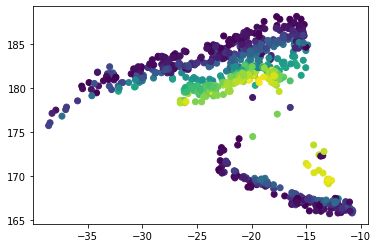

In [2]:
df=sm.datasets.get_rdataset('quakes').data
print(df.head(4))
plt.scatter(df['lat'], df['long'], c=df['depth'])

Shown above is the lat/lon locations of the earthquakes, colored by their depths.  Certainly there is some structure here and distinct divisions between regions, so it might make sense to model it using clustering.

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Hierarchical Seeding 15 pts)


We begin with the locational problem of just latitude versus longitude.  As an eye-check, we decide that $k=2$ might be appropriate here.  

Suppose we choose a small subset of the data to perform hierarchical clustering on.


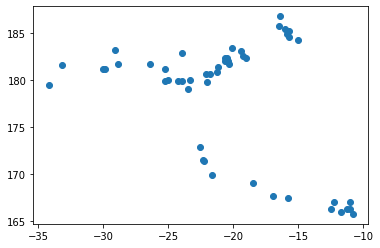

In [3]:
np.random.seed(4022)
subset=df.loc[:,['lat','long','depth']].sample(n=50)
plt.scatter(subset['lat'], subset['long'])

**Part A**:  Perform hierarchical clustering on the 50-observation dataset in `subset`, with $k=2$.  Make a plots of the results that colors the scatter plot above by the resulting clusters, and print out the *centroids* of the two final clusters.

---

**I assume $k=2$ here because it says we eyeball 2 clusters to be sufficient, and it later says we initialize with two centroids. I've changed $k$ above to reflect this...**

---

In [4]:
#######################################################################################################
# Simple n-dimensional point object
#######################################################################################################
class Point:
    '''
    INPUT:
        c:           list or tuple of coordinates that represent a point with n-dimensions
    ----------------------------------------------------------------------------------------
    SELF:
        coordinates: converted tuple of the list/tuple that is inputted as c
        n:           number of dimensions calculated by taking the length of c
    '''
    def __init__(self, c):
        self.coordinates = tuple(c)
        self.n           = len(c)
    
    def __repr__(self):
        temp = ''.join(["{:.2f}, ".format(self.coordinates[i]) for i in range(self.n - 1)])
        s = "(" + temp + "{:.2f})".format(self.coordinates[-1])
        return s
    
    def euclidean_distance(self, p2):
        return np.linalg.norm(np.array(self.coordinates) - np.array(p2.coordinates))
        '''return np.sqrt(np.sum([(self.coordinates[i] - p2.coordinates[i]) ** 2 for i in range(self.n)]))'''
    
#######################################################################################################
# Cluster Object
#######################################################################################################
class Cluster:
    '''
    INPUT:
        points:   Can accept a list of points for initialization, default is an empty list
        
        It's funny, I actually had this from the get-go but I was too stubborn to use it in 
        kMeans ultimately causing a major slowdown.
    ----------------------------------------------------------------------------------------
    SELF:
        points:   List of Point objects of the given Cluster Object
        centroid: The centroid of the given Cluster given the list of Point objects
        avg_dist: The average distance each Point is to the centroid in the given Cluster
        index:    The number used for returning a color list at the end
        n:        Number of dimensions calculated by taking the dimension from the given Point object 
    '''
    def __init__(self, points=[]):
        self.points     = []
        self.centroid   = None
        self.avg_dist   = None
        self.index      = None
        self.n          = None
        if len(points) > 0:
            self.points = points
            self.n      = self.points[0].n
            self.compute_centroid()
            self.compute_avg_distance()
    
    # Printing purposes
    def __repr__(self):
        return "Index: {}\nCentroid: {}\nAvg. Distance: {:.2f}\nPoints: {}\nNumber of Points: {}\n".format(self.index, self.centroid, self.avg_dist, self.points, len(self.points))
    
    # Returns the list of points in a given cluster
    def get_points(self):
        return self.points

    # Sets the index of a cluster for coloring purposes
    def set_index(self, i):
        self.index = i
    
    # Adds a point to the list of points and computes the new centroid of the cluster
    # and the average distance of each point from the cluster
    def add_point(self, point):
        self.points.append(point)
        if len(self.points) == 1:
            self.centroid = point
            self.avg_dist = 0.0
            self.n        = point.n
        else:
            # This is where my slow speed was coming from.
            # Mostly the compute_avg_distance, I should make an update function for this. 
            self.update_centroid()
            self.compute_avg_distance()
    
    '''
    ADDED THIS METHOD FOR KMEANS: 
    Now I could add a list of points at the end of iterating through all of them.
    Major speed-up.
    
    '''
    # Adds a list of points to the given list of points, and ccomputes 
    # the new centroid of the cluster and the average distance of each point from the cluster
    def add_points(self, points):
        self.points.extend(points)
        if len(self.points) == 1:
            self.centroid = point
            self.avg_dist = 0.0
            self.n        = point.n
        else:
            self.compute_centroid()
            self.compute_avg_distance()
    
    # Added this for kMeans so I could add initial centroids without adding a 
    # point to the cluster
    def add_centroid(self, point):
        if len(self.points) == 0: 
            self.centroid = point
            self.avg_dist = 0.0
            self.n        = point.n
    
    # This function is kinda necessary for removing points
    def compute_centroid(self):
        means = [np.mean([pt.coordinates[i] for pt in self.points]) for i in range(self.n)]
        self.centroid = Point(means)
    
    # Updates the centroid, less computationally expensive then 
    # computing it from scratch
    def update_centroid(self):
        len_pts       = len(self.points)
        old           = [self.centroid.coordinates[i] for i in range(self.n)]
        new           = [self.points[-1].coordinates[i] for i in range(self.n)]
        update        = [(old[i] + ((new[i] - old[i]) / len_pts)) for i in range(self.n)]
        self.centroid = Point(update)
    
    # Computes the average distance of each point to the centroid
    def compute_avg_distance(self):
        distances = []
        for point in self.points:
            distances.append(self.centroid.euclidean_distance(point))
        self.avg_dist = np.mean(distances)
    
    # Removes a point if it is present in the list of points
    def remove_point(self, point):
        try:
            self.points.remove(point)
            self.compute_centroid()
            self.compute_avg_distance()
        except ValueError:
            return
        
#######################################################################################################
# Hierarchical CLustering Object
#######################################################################################################        
class Hierarchical_Clustering:
    '''
    INPUT:
        points: Needs a list of points to cluster on, wants the Point objects I created above
        k:      Needs a number of clusters to cluster the points into  
    ----------------------------------------------------------------------------------------
    SELF:
        points:   The inputted list of Point objects
        k:        The inputted number of clusters to end on
        clusters: The list of Cluster objects
    '''
    def __init__(self, points, k):
        self.points     = points
        self.k          = k
        self.clusters   = []
        for pt in points:
            c = Cluster()
            c.add_point(pt)
            self.clusters.append(c)
    
    # Returns all points 
    def get_points(self):
        return self.points
    
    # Performs hierarchical clustering, and returns the clusters of the given points
    # and the centroids of the clusters
    def Perform_Hierarchical(self, print_clusters=True):
        init_k = len(self.clusters)
        
        # as we merge 
        while init_k != self.k:
            d = np.full((init_k, init_k), np.inf)
            
            # triangular matraix of distances from cluster[i]'s centroid to cluster[j]'s centroid.
            for i in range(len(self.clusters)):
                for j in range(i, len(self.clusters)):
                    if self.clusters[i] != self.clusters[j]:
                        d[i][j] = self.clusters[i].centroid.euclidean_distance(self.clusters[j].centroid)
            
            indices = np.where(d == np.min(d))
            ind_1   = indices[0][0]
            ind_2   = indices[1][0]
            
            self.merge_clusters(self.clusters[ind_1], self.clusters[ind_2])
            
            init_k = len(self.clusters)
        
        if print_clusters:
            for cluster in self.clusters:
                print(cluster)
        
        cluster_indices = self.get_cluster_colors()
        centroids = [self.clusters[i].centroid for i in range(len(self.clusters))]
        
        return cluster_indices, centroids
    
    # Gets the colors / indices of each cluster for the points.
    # Also sets the indices of the cluster objects
    def get_cluster_colors(self):
        cluster_indices = np.zeros(len(self.points))
        for cluster in self.clusters:
            for point in cluster.get_points():
                cluster_indices[self.points.index(point)] = cluster.index
        return cluster_indices
    
    # Merges two clusters given that both of them exist (they always will in hierarchical)
    def merge_clusters(self, c1, c2):
        try:
            self.clusters.remove(c2)
            i1 = self.clusters.index(c1)
            for p in c2.get_points():
                self.clusters[i1].add_point(p)
            for i in range(len(self.clusters)):
                self.clusters[i].set_index(i)
        except ValueError:
            return   

#######################################################################################################
# K Means CLustering Object
#######################################################################################################
class kMeans_Clustering:
    '''
    INPUT:
        points:           Needs a list of points to cluster on, wants the Point objects I created above
        k:                Needs a number of clusters to cluster the points into  
        init_points:      Can input a list of initial Point objects as initial clusters. Only takes up to
                          k initial points. Default is empty list, and will randomly select a point and then 
                          furthest points subsequently.
        random:           If random is set to True, all the points are picked randomly. Default is False.
        convergence_term: Can input a convergence term to change when the algorithm terminates. 
                          Currently, the algorithm sums the distance in centroids as they change so
                          it is best to be less than 1. Default is 1e-10.
    ----------------------------------------------------------------------------------------
    SELF:
        points:   The inputted list of Point objects
        k:        The inputted number of clusters to end on
        clusters: The list of Cluster objects
    '''
    def __init__(self, points, k, init_points=[], random=False, convergence_term=1e-10):
        self.points     = points
        self.k          = k
        self.clusters   = []
        self.convergence_term = convergence_term
        i = 0
        for pt in init_points:
            if i < k:
                c = Cluster()
                c.add_centroid(pt)
                self.clusters.append(c)
            i += 0
        furthest_points = k - len(self.clusters)
        if random:
            pts = np.random.choice(self.points, furthest_points, False)
            for pt in pts:
                c = Cluster()
                c.add_centroid(pt)
                self.clusters.append(c)
            furthest_points -= furthest_points
        if furthest_points == k:
            pt = np.random.choice(self.points)
            c = Cluster()
            c.add_centroid(pt)
            self.clusters.append(c)
            furthest_points -= 1
        if furthest_points != 0: 
            for i in range(furthest_points):
                dist = []
                for pt in self.points:
                    dist.append(np.sum([pt.euclidean_distance(init_points[i]) for i in range(len(init_points))]))
                c = Cluster()
                c.add_centroid(self.points[dist.index(np.max(dist))])
                self.clusters.append(c)  

    # Returns all points                             
    def get_points(self):
        return self.points
    
    # Performs K Means clustering, and returns the clusters of the given points
    # and the centroids of the clusters    
    def Perform_kMeans(self, print_clusters=True):
        # have to flip the names here to get it to work
        new_centroids = self.get_cluster_centroids()
        old_centroids = self.initialize_new_centroids()
        c_distance = np.sum([old_centroids[i].euclidean_distance(new_centroids[i]) for i in range(len(old_centroids))])

        convergence = False if c_distance >= self.convergence_term else True
        
        points       = self.get_points()
        point_matrix = np.matrix([p.coordinates for p in points])
        num_points   = len(points)
        
        while (not convergence):
            centroid_matrix = np.matrix([centroid.coordinates for centroid in new_centroids])
            distances = [[np.linalg.norm(point_matrix[j] - centroid_matrix[i]) for i in range(self.k)] for j in range(num_points)]
            indices = [distance.index(min(distance)) for distance in distances]

            d = {i: [] for i in range(self.k)}
            for i in range(num_points):
                d[indices[i]].append(points[i])
            
            for i in range(self.k):
                self.clusters[i].add_points(d[i])
                

            old_centroids = new_centroids
            new_centroids = self.get_cluster_centroids()
            c_distance = np.sum([old_centroids[i].euclidean_distance(new_centroids[i]) for i in range(self.k)])
            
            convergence = False if c_distance >= self.convergence_term else True
            
            if not convergence:
                self.clusters = []
                for centroid in new_centroids:
                    c = Cluster()
                    c.add_centroid(centroid)
                    self.clusters.append(c)
  

        self.print_clusters(print_clusters)
            
        cluster_indices = self.get_cluster_colors()
        centroids = [self.clusters[i].centroid for i in range(len(self.clusters))]
        return cluster_indices, centroids
    
    # List comprehension to get the cluster centroids in a list
    def get_cluster_centroids(self):
        return [Point([cluster.centroid.coordinates[i] for i in range(cluster.n)]) for cluster in self.clusters]
    
    # List comprehension to initialize necessary number of centroids to 0 (zero)
    def initialize_new_centroids(self):
        return [Point([0 for i in range(cluster.n)]) for cluster in self.clusters]
    
    # prints the clusters if the flag is set to True in Perform_kMeans
    # flag is set to true as default
    def print_clusters(self, print_clusters):
        i = 0
        for cluster in self.clusters:
            cluster.set_index(i)
            if print_clusters:
                print(cluster)
            i += 1
    
    # Gets the colors / indices of each cluster for the points.
    # Also sets the indices of the cluster objects
    def get_cluster_colors(self):
        cluster_indices = np.zeros(len(self.points))
        for cluster in self.clusters:
            for point in cluster.get_points():
                cluster_indices[self.points.index(point)] = cluster.index
        return cluster_indices

Index: 0
Centroid: (-22.38, 182.06)
Avg. Distance: 4.43
Points: [(-20.64, 182.02), (-20.42, 181.96), (-20.51, 182.30), (-20.60, 182.28), (-20.32, 181.69), (-19.22, 182.54), (-18.98, 182.32), (-19.41, 183.05), (-20.12, 183.40), (-22.03, 179.77), (-21.16, 181.41), (-21.24, 180.81), (-22.06, 180.60), (-21.75, 180.67), (-25.28, 181.17), (-26.40, 181.70), (-24.27, 179.88), (-23.97, 179.91), (-23.36, 180.01), (-23.49, 179.07), (-25.00, 180.00), (-25.25, 179.86), (-23.95, 182.80), (-15.85, 184.83), (-15.70, 184.50), (-16.03, 185.43), (-15.67, 185.23), (-16.44, 185.74), (-15.02, 184.24), (-16.43, 186.73), (-29.09, 183.20), (-30.04, 181.20), (-29.90, 181.16), (-28.83, 181.66), (-34.20, 179.43), (-33.20, 181.60)]
Number of Points: 36

Index: 1
Centroid: (-15.75, 168.21)
Avg. Distance: 4.74
Points: [(-12.28, 167.06), (-12.49, 166.36), (-10.80, 165.80), (-11.25, 166.36), (-10.98, 166.32), (-11.67, 166.02), (-11.02, 167.01), (-18.49, 169.04), (-15.78, 167.44), (-16.96, 167.70), (-21.60, 169.90), (-

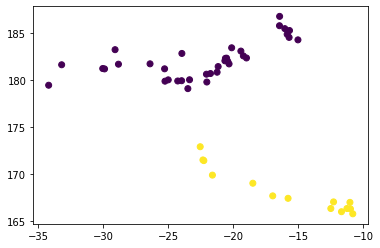

In [5]:
k = 2

lat  = list(subset['lat'])
long = list(subset['long'])
pts = [Point((lat[i], long[i])) for i in range(len(subset))]

H_C = Hierarchical_Clustering(pts, k)
cluster_colors, centroids = H_C.Perform_Hierarchical()

unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(subset['lat'], subset['long'], c=cluster_colors)

**Part B**:  Perform k-means clustering on the original dataset in `df` using only the `lat` and `long` columns, with $k=3$.  Initialize using the two cluster centroids from **Part A**.  Make a plots of the results that colors the original lat-lon scatter plot by their resulting clusters.

{0.0: 540, 1.0: 205, 2.0: 255}


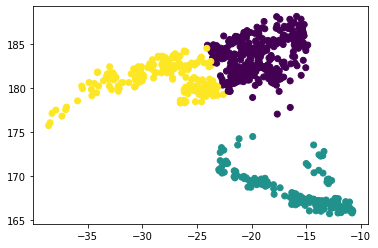

In [6]:
k = 3

lat  = list(df['lat'])
long = list(df['long'])
pts = [Point((lat[i], long[i])) for i in range(len(df))]

kM_C = kMeans_Clustering(pts, k, centroids)
cluster_colors, centroids = kM_C.Perform_kMeans(False)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(df['lat'], df['long'], c=cluster_colors)

---

I implement my k-Means to be able to take in a list of initial centroid points and will pick subsequent required points as far a distance as possible from the initial cedntroids. Also, my implementation waits for the centroids to stablize rather than track point movement. I'm gonna run hierarchical with $k=3$ to see how this affects things. It appears it does little to change.

**Edit after running the test below:** After bug smashing and  

---

{0.0: 30, 1.0: 6, 2.0: 14}


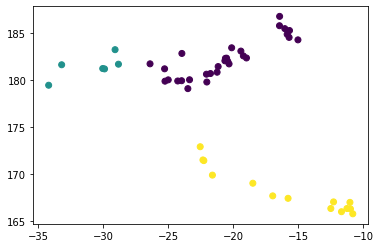

In [7]:
lat  = list(subset['lat'])
long = list(subset['long'])
pts = [Point((lat[i], long[i])) for i in range(len(subset))]

H_C = Hierarchical_Clustering(pts, k)
cluster_colors, centroids = H_C.Perform_Hierarchical(False)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(subset['lat'], subset['long'], c=cluster_colors)

{0.0: 540, 1.0: 255, 2.0: 205}


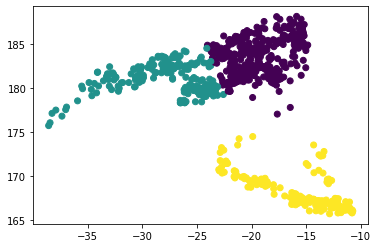

In [8]:
lat  = list(df['lat'])
long = list(df['long'])

pts = [Point((lat[i], long[i])) for i in range(len(df))]

kM_C = kMeans_Clustering(pts, k, centroids)
cluster_colors, centroids = kM_C.Perform_kMeans(False)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(df['lat'], df['long'], c=cluster_colors)

***
<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (To Scale or Not to Scale?; 15 pts)

Suppose we move on to the task of adding `depth` to our model, so we'll cluster using the 3 columns `lat`, `long`, and `depth`.


**Part A**:

The first question we should ask is whether or not to normalize our data.  Use the pandas methods `describe` on the data frame.  What do you expect to happen if we cluster without normalizing the data?  Why?


In [9]:
df.describe()

,lat,long,depth,mag,stations
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-20.642750,179.462020,311.371000,4.620400,33.418000
std,5.028791,6.069497,215.535498,0.402773,21.900386
min,-38.590000,165.670000,40.000000,4.000000,10.000000
25%,-23.470000,179.620000,99.000000,4.300000,18.000000
50%,-20.300000,181.410000,247.000000,4.600000,27.000000
75%,-17.637500,183.200000,543.000000,4.900000,42.000000
max,-10.720000,188.130000,680.000000,6.400000,132.000000


---

So initially, it's obvious we'd want to normalize our data because the latitude-longitude distance makes some sense in the context of this problem (although there are many cool python packages that can help with the spherical formula/calculation), however once we add depth, it's kind of difficult to quantify what these distances are. Much like the example in class/on slides when we consider vehicle weight and mpg, weight per mpg isn't a distance, although a normalized euclidean distance can be useful.

**Edit after running tests in Part B.:** Well, it turns out the incredibly large standard deviation of `depth` compared to the `long` and `lat` columns creates some weird behavior. I think it's because my kMeans with Euclidean distance is using circles when we either need to normalize our data or use a different distance function that fits ellipses to our clusters.

**Afterword:** So I just had several bugs in my kMeans algorithm and then it's long computation times made it impossible to really test until I fixed the speed issue.

---

**Part B**:

Implement the k-means clustering algorith by hand for $k=3$, using your choice of initialization.  Plot the final clusters on an `lat` versus `long` axis.


Index: 0
Centroid: (-21.90, 180.95, 539.89)
Avg. Distance: 41.33
Points: [(-20.64, 182.02, 497.00), (-20.51, 182.30, 492.00), (-25.00, 180.00, 488.00), (-25.25, 179.86, 491.00), (-24.27, 179.88, 523.00), (-23.97, 179.91, 518.00), (-20.60, 182.28, 529.00), (-20.32, 181.69, 508.00), (-23.49, 179.07, 544.00), (-21.16, 181.41, 543.00), (-23.36, 180.01, 553.00), (-18.98, 182.32, 442.00), (-22.03, 179.77, 587.00), (-22.06, 180.60, 584.00), (-21.75, 180.67, 595.00), (-21.24, 180.81, 605.00), (-19.22, 182.54, 570.00), (-20.42, 181.96, 649.00)]
Number of Points: 18

Index: 1
Centroid: (-19.45, 174.74, 84.26)
Avg. Distance: 36.46
Points: [(-29.09, 183.20, 54.00), (-30.04, 181.20, 49.00), (-22.54, 172.91, 54.00), (-34.20, 179.43, 40.00), (-15.78, 167.44, 40.00), (-16.96, 167.70, 45.00), (-21.60, 169.90, 43.00), (-16.43, 186.73, 75.00), (-15.67, 185.23, 66.00), (-11.02, 167.01, 62.00), (-12.49, 166.36, 74.00), (-22.26, 171.44, 83.00), (-10.80, 165.80, 175.00), (-33.20, 181.60, 153.00), (-22.33, 17

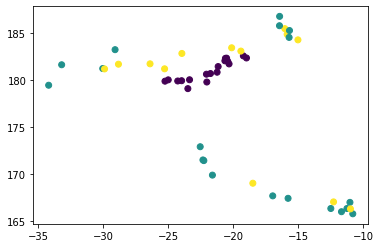

In [10]:
lat  = list(subset['lat'])
long = list(subset['long'])
depth = list(subset['depth'])
pts   = [Point((lat[i], long[i], depth[i])) for i in range(len(subset))]

H_C = Hierarchical_Clustering(pts, k)
cluster_colors, centroids = H_C.Perform_Hierarchical(True)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(subset['lat'], subset['long'], c=cluster_colors)

{0.0: 387, 1.0: 386, 2.0: 227}


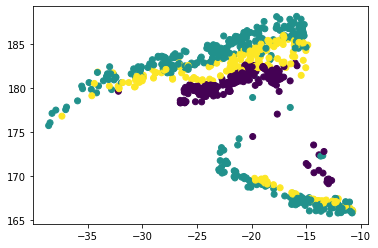

In [11]:
lat   = list(df['lat'])
long  = list(df['long'])
depth = list(df['depth'])
pts   = [Point((lat[i], long[i], depth[i])) for i in range(len(df))]

kM_C = kMeans_Clustering(pts, k, centroids)
cluster_colors, centroids = kM_C.Perform_kMeans(False)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(df['lat'], df['long'], c=cluster_colors)

**Part C**:

Create a new data frame by *normalizing* the 3 columns being used in **Part B**.  For each such column, replace it with its standard Z-score normalization (for each column, subtract the mean of that column then divide by its standard deviation).  

Afterwards, implement the k-means clustering algorith by hand for $k=3$, using the same initialization as you used above.   Plot the final clusters on an `lat` versus `long` axis.

Index: 0
Centroid: (0.06, 0.62, 0.66)
Avg. Distance: 0.94
Points: [(-0.02, 0.59, 0.99), (0.00, 0.63, 0.97), (0.04, 0.54, 1.04), (-0.01, 0.63, 1.15), (-0.11, 0.49, 1.22), (0.23, 0.67, 1.35), (0.27, 0.63, 0.72), (-0.26, 0.24, 1.44), (-0.27, 0.37, 1.42), (-0.22, 0.38, 1.47), (-0.13, 0.40, 1.52), (0.02, 0.58, 1.74), (-0.66, 0.26, 1.12), (-0.61, 0.26, 1.09), (-0.52, 0.14, 1.22), (-0.50, 0.28, 1.27), (-0.79, 0.28, 0.95), (-0.83, 0.26, 0.96), (0.82, 1.02, 0.01), (0.79, 1.11, 0.00), (0.97, 0.93, 0.21), (0.07, 0.80, -0.06), (0.20, 0.74, 0.02), (0.72, 1.31, -1.10), (0.86, 1.08, -1.14), (0.85, 0.97, -0.88), (0.72, 1.16, -0.84)]
Number of Points: 27

Index: 1
Centroid: (-1.49, 0.51, -0.57)
Avg. Distance: 0.74
Points: [(-1.51, 0.77, -1.20), (-1.68, 0.46, -1.23), (-2.41, 0.19, -1.27), (-2.23, 0.52, -0.71), (-1.65, 0.46, -0.40), (-1.46, 0.53, -0.37), (-0.84, 0.46, 0.35), (-1.03, 0.54, 0.16), (-0.60, 0.71, -0.48)]
Number of Points: 9

Index: 2
Centroid: (0.84, -1.52, -0.91)
Avg. Distance: 0.91
Points:

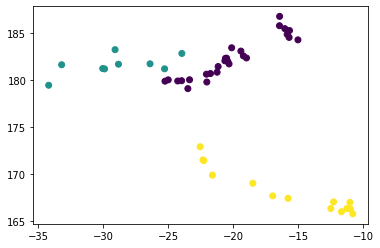

In [12]:
# Although I'm not creating a new dataframe, 
# I've elected to leave it as lists because thats what my clustering code accepts
norm_lat   = list((subset['lat'] - np.mean(subset['lat'])) / np.std(subset['lat']))
norm_long  = list((subset['long'] - np.mean(subset['long'])) / np.std(subset['long']))
norm_depth = list((subset['depth'] - np.mean(subset['depth'])) / np.std(subset['depth']))
pts   = [Point((norm_lat[i], norm_long[i], norm_depth[i])) for i in range(len(subset))]

H_C = Hierarchical_Clustering(pts, k)
cluster_colors, centroids = H_C.Perform_Hierarchical(True)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(subset['lat'], subset['long'], c=cluster_colors)

{0.0: 430, 1.0: 373, 2.0: 197}


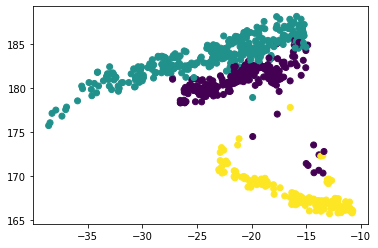

In [13]:
norm_lat   = list((df['lat'] - np.mean(df['lat'])) / np.std(df['lat']))
norm_long  = list((df['long'] - np.mean(df['long'])) / np.std(df['long']))
norm_depth = list((df['depth'] - np.mean(df['depth'])) / np.std(df['depth']))
pts   = [Point((norm_lat[i], norm_long[i], norm_depth[i])) for i in range(len(df))]

kM_C = kMeans_Clustering(pts, k, centroids)
cluster_colors, centroids = kM_C.Perform_kMeans(False)

# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
# just to double check the counts
unique, counts = np.unique(cluster_colors, return_counts=True)
print(dict(zip(unique, counts)))

plt.scatter(df['lat'], df['long'], c=cluster_colors)

**Part D**:

Then answer: do the clusterings look different?  Do they look better?

---

Yes they look quite different. I would say three 'bands' from the normalized clusters looks way better than having close to six bands of alternating clusters. The unnormalized clustering didn't make that much sense unsurprisingly.

---

***
<a/ id='p3'></a>
[Back to top](#top)

# Problem 3 (Rand Statistics and Random Initialization; 15 pts)



###  ...and then repeat.

So how "different" were those clusterings in Problem 2?  Can we measure it?  We should also be slightly concerned: since kmeans might *also* depend on initialization, we want to make sure that your initialization in problem 2 aren't affecting your clusters.  One way to ensure that we don't get "unlucky" results is to repeat our experiment with many different initializations, and then choose the "best" one.  A Rand statistic gives us a mechanism to do this!


**Part A**: 

Run k-means 100 times for $k=3$ on the *unnormalized* data, each with a different random initialization.

In other words, perform the following operations 100 times:

    1) Initialize k-means by randomly selecting `k' of your data points
    2) Run k-means until convergence
    3) Save the final cluster for each point
    
    
A few rows of your final k=3 output might be:

`dfunnorm.head(3)'

| Point # | Run1 | Run2 | Run3 | ... | Run 100 |
| --- | --- |
| 1 | 1 | 2 | 1| ... | 1 |
| 2 | 3 | 1 | 3 | ... | 3|
| 3 | 1 | 2 | 1 | ... | 1|

(so in this example, points 1 & 3 were always in the same cluster, but point 2 was elsewhere)



In [14]:
runs = 100

k = 3

lat   = list(df['lat'])
long  = list(df['long'])
depth = list(df['depth'])
pts   = [Point((lat[i], long[i], depth[i])) for i in range(len(df))]

unnorm_runs = []

for run in range(runs):
    kM_C = kMeans_Clustering(pts, k, random=True, convergence_term=1e-1)
    cluster_colors, centroids = kM_C.Perform_kMeans(False)
    unnorm_runs.append(list(cluster_colors))


dfunnorm = pd.DataFrame(np.matrix(unnorm_runs).T, columns=['Run {}'.format(i) for i in range(runs)])
dfunnorm.head(3)

,Run 0,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,...,Run 90,Run 91,Run 92,Run 93,Run 94,Run 95,Run 96,Run 97,Run 98,Run 99
0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,...,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0
1,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,...,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0
2,2.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,...,0.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0


**Part B**: 

Run k-means 100 times for $k=3$ on the *normalized* data, each with a different random initialization.  Save the results in another data frame.

In [15]:
norm_lat   = list((df['lat'] - np.mean(df['lat'])) / np.std(df['lat']))
norm_long  = list((df['long'] - np.mean(df['long'])) / np.std(df['long']))
norm_depth = list((df['depth'] - np.mean(df['depth'])) / np.std(df['depth']))
pts        = [Point((norm_lat[i], norm_long[i], norm_depth[i])) for i in range(len(df))]

norm_runs = []

for run in range(runs):
    kM_C = kMeans_Clustering(pts, k, random=True, convergence_term=1e-1)
    cluster_colors, centroids = kM_C.Perform_kMeans(False)
    norm_runs.append(list(cluster_colors))


dfnorm = pd.DataFrame(np.matrix(norm_runs).T, columns=['Run {}'.format(i) for i in range(runs)])
dfnorm.head(3)

,Run 0,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,...,Run 90,Run 91,Run 92,Run 93,Run 94,Run 95,Run 96,Run 97,Run 98,Run 99
0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,...,1.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,2.0


**Part C**: 

For the 100 runs on the unnormalized data, create a similarity matrix of all-pairwise Rand scores.  Select the run with the highest overall summed Rand scores as the "most indicative run" (note: this is actually the clustroid of the clusters, if we consider Rand similarity an inverse distance!).   Plot the final clusters on an `lat` versus `long` axis.


97.9444966087461


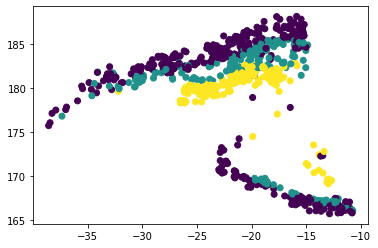

In [16]:
scores = np.zeros((runs, runs))
for i1 in range(runs):
    for i2 in range(runs):
        if i1 != i2:
            score = adjusted_rand_score(unnorm_runs[i1], unnorm_runs[i2])
            scores[i1][i2] = score

sums = []
for row in scores:
    s = np.sum(row)
    sums.append(s)

print(np.max(sums)) 

# just takes the first winner, although I had several winners
unnorm_winner = unnorm_runs[np.argmax(sums)]

plt.scatter(df['lat'], df['long'], c=unnorm_winner)


**Part D**: 

For the 100 runs on the normalized data, create a similarity matrix of all-pairwise Rand scores.  Select the run with the highest overall summed Rand scores as the "most indicative run."   Plot the final clusters on an `lat` versus `long` axis.



87.72404420712672


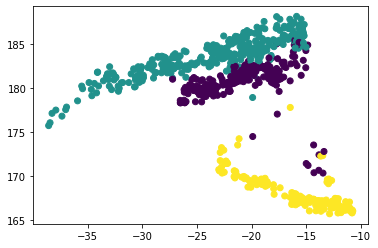

In [17]:
scores = np.zeros((runs, runs))
for i1 in range(runs):
    for i2 in range(runs):
        if i1 != i2:
            score = adjusted_rand_score(norm_runs[i1], norm_runs[i2])
            scores[i1][i2] = score

sums = []
for row in scores:
    s = np.sum(row)
    sums.append(s)

print(np.max(sums)) 

# just takes the first winner, although I had several winners
norm_winner = norm_runs[np.argmax(sums)]

plt.scatter(df['lat'], df['long'], c=norm_winner)

**Part E**: 

Compare the two runs selected by parts C and D.  Are they identical, or can we definitively say that normalization effects the clustering in this problem?


In [18]:
print(adjusted_rand_score(norm_winner, unnorm_winner))

0.5200969893517658


---

From [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html): 
> Similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.

and:
> The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

So I'm not totally sure how to interpret $0.52$ because I would have thought that we would've seen a value less than zero if they weren't similar at all. The clusterings don't seem that similar, so I'm just confused with interpretting the ARS. I understand that it takes into account the randomness of matching, but I don't get what $-1$ means. I suppose they should be somewhat similar because it's the same data. Regardless of my rant, it appears visually and at least to a degree numerically that normalization *DOES* matter.

---

**Part F**: 

What do you think is the correct number of clusters for this problem?  Does it depend on whether or not we're using the `depth` column?  Explain your thought process, but you don't need to formally compare results of $k=2$ and $k=3$... we'll do that next week when we use GMMs on this!

---

I like $k=2$ more just because the data seems to be split like that naturally. However, I also think it depends on `depth`, and I ultimately think slightly larger values of $k$ are more interesting too. Once we add the `depth` column, we see three pretty neat bands of clustered data points (although we do have some weird outliers). It would have been interesting to run the 3D data with 4 or 5 clusters.

---